## Forest CoverType Prediction

In this competition you are asked to predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. Independent variables were then derived from data obtained from the US Geological Survey and USFS. The data is in raw form (not scaled) and contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.

In [33]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

### • Data Ingestion

In [34]:
# read data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sampleSubmission.csv')
save_prediction_index = sample_submission.index

print('Train:', df_train.shape) 
print('Test:', df_test.shape)

Train: (15120, 56)
Test: (565892, 55)


In [35]:
df_train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


### • Data Preprocessing

In [36]:
y_train = df_train['Cover_Type']
X_train = df_train.drop(['Id', 'Cover_Type'], axis=1)
X_test = df_test.drop(['Id'], axis=1)

# shuffle train data
X_train, y_train = shuffle(X_train, y_train)

### • EDA (numerical features)

I'm going to inspect relationships between continious variables.

<AxesSubplot:>

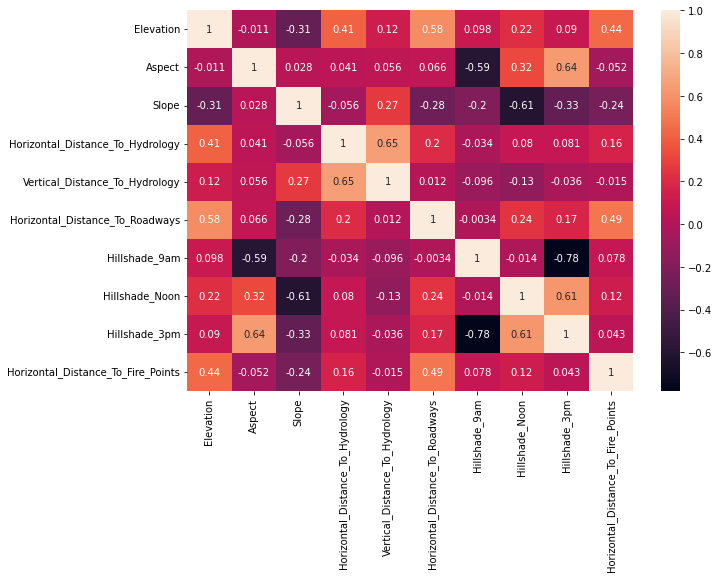

In [37]:
num_columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
               'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
numerical_features = X_train[num_columns]

plt.figure(figsize=(10, 7))
sns.heatmap(numerical_features.corr(), annot=True)

* **Elevation** is correlated with features with contain distance to the particular object.
* **Aspect** is correlated with **Hillshade_9am**.
* **Hillshade_Noon** is correlated with **Slope**.
It means that hillshade depends on terrain and location.
* etc.

This correlation matrix will help with feature engineering: creating new features.

### • Feature Selection (Random Forest feature importance)

I am going to train Random Forest with default parameters in order to find meaningful features.

In [38]:
def feature_importance(X_train, number):
    rfc = RandomForestClassifier()    
    rfc.fit(X_train, y_train)
    # display important features
    sorted_idx = rfc.feature_importances_.argsort()[-number:]
    plt.barh(X_train.columns[sorted_idx], rfc.feature_importances_[sorted_idx])
    plt.xlabel("Random Forest Feature Importance")

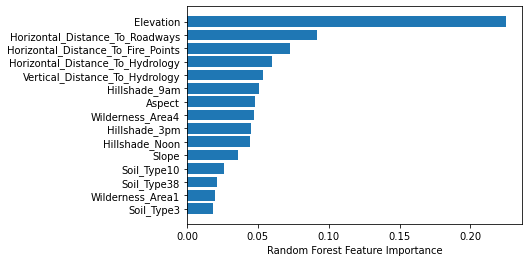

In [39]:
feature_importance(X_train, 15)

Continious variables are more important than binary categorical features. Distance and elevation gives more information about cover type than hillshape or terrain aspects.

### • Feature Engineering

Here I focused on creating features related to evaluation and distance.

In [40]:
# feature engineering
for data in [X_train, X_test]:
    data['Area_to_Hydrology'] = data['Horizontal_Distance_To_Hydrology'] * data['Vertical_Distance_To_Hydrology']
    data['Hillshade_mean'] = (data['Hillshade_3pm'] + data['Hillshade_9am'] + data['Hillshade_Noon']) / 3
    data['Area_Elevation_To_Roadways'] = (data['Elevation'] * data['Horizontal_Distance_To_Roadways']) 
    data['Area_Elevation_To_Hydrology'] = (data['Elevation'] * data['Horizontal_Distance_To_Hydrology'])
    data['Area_Elevation_To_Fire_Points'] = (data['Elevation'] * data['Horizontal_Distance_To_Fire_Points'])
    data['Elevation_Binarized'] = pd.cut(data['Elevation'], 7, labels=[x for x in range(1, 8)])

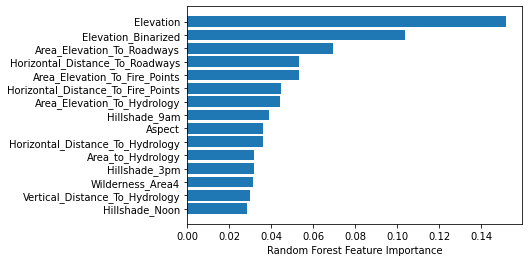

In [49]:
feature_importance(X_train, 15)

As we see, some of the newly created features turned out to be significant.

### Model Selection

In [41]:
# ensemble learning
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

• Random Forest parameter tuning

In [42]:
# parameter grid
rf_grid = {
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 150],
    'max_depth': np.arange(1, 100, 10),  
    'max_features' : ['sqrt', 'log2', 0.5], 
}

rfc = RandomForestClassifier(bootstrap=True)
clf = RandomizedSearchCV(rfc, rf_grid)
rfc = clf.fit(X_train, y_train)

print('Parameters', rfc.best_params_)
print('Score', rfc.best_score_)

Parameters {'n_estimators': 64, 'max_features': 'log2', 'max_depth': 51}
Score 0.8638888888888889


• Extra Tree Classifier

In [43]:
# parameter grid
etc_grid = {
    'n_estimators': np.arange(100, 1000, 100),
    'max_depth': np.arange(1, 100, 10),  
    'max_features' : ['sqrt', 'log2', 0.5], 
}

In [44]:
# parameter tuning
etc = ExtraTreesClassifier()
etc_search = RandomizedSearchCV(etc, rf_grid)
etc_search.fit(X_train, y_train)

print('Parameters', etc_search.best_params_)
print('Score', etc_search.best_score_)

Parameters {'n_estimators': 100, 'max_features': 0.5, 'max_depth': 31}
Score 0.8832671957671957


• AdaBoostClassifier

In [47]:
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
abc.score(X_train, y_train)

0.5136904761904761

## Save model

In [48]:
sample_submission['Cover_Type'] = etc_search.predict(X_test)
sample_submission.to_csv('output_rf.csv', index=False)

## Conclusion

This notebook represents only part of the work I have done in this competition. 
Here are some notes about work process.

* Tried different models: kNN, Random Forest, SVC, Naive Bayes Classifier. Initially Random Forest has been chosen, as it has shown better perfomance than other models. 
* Data scaling did't help. But shuffeling data helped when I did cross-validation.
* Dimentionality reduction didn't help.
* Adding new featutes helped to increase score while training Random Forest.
* Hyperparameter tuning helped a bit, but it seems that Random Forest has it's own limit of accuracy in this competition. That's whyit was decided to consider other ensemble methods that were not taken in the course.  

As a result, I ended up with ExtraTreesClassifier. It has shown better perfomance on the test data on Kaggle. And after tuning the hyperparameters, I got a good score. 